In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import copy

In [3]:
from statistics import mode

In [4]:
from datetime import datetime

In [5]:
from bs4 import BeautifulSoup

In [6]:
from PIL import Image

In [7]:
import numpy as np
import pandas as pd

In [8]:
from dst_incidence.amazon_prices import PriceHistoryCollector
from dst_incidence.utils import get_dates_from_text_extract

In [9]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = "/usr/local/Cellar/tesseract/5.2.0/bin/tesseract"

In [10]:
import re

In [11]:
import matplotlib.pyplot as plt

In [12]:
collector = PriceHistoryCollector(
    data_raw_dir="/Users/Paul-Emmanuel/Desktop/PhD/3_DST_incidence/data_raw",
    sku_reference='B0016MNAAI', 
    country='Germany'
)

In [13]:
collector.fetch_product_information()

In [14]:
collector.price_history_summary

,Type de prix,Le plus bas jamais atteint *,Le plus élevé de tous les temps *,Actuel +,Moyenne *
0,Amazon,"102,00€ (24 oct. 2015)","159,00€ (06 mai 2016)",-,"114,70€"
1,Nouveauté 3ème partie,"101,02€ (03 oct. 2018)","229,87€ (11 avr. 2021)","139,00€ (03 jan. 2024)","160,21€"
2,3eme occasion,"49,95€ (09 mai 2015)","283,65€ (16 mar. 2023)","111,20€ (18 jan. 2024)","135,24€"


In [15]:
collector.full_product_name

'beyerdynamic DT 770 PRO 80 Ohm Over-Ear-Studiokopfhörer in schwarz. Geschlossene Bauweise, kabelgebu.html'

In [16]:
collector.build_price_history_from_charts()

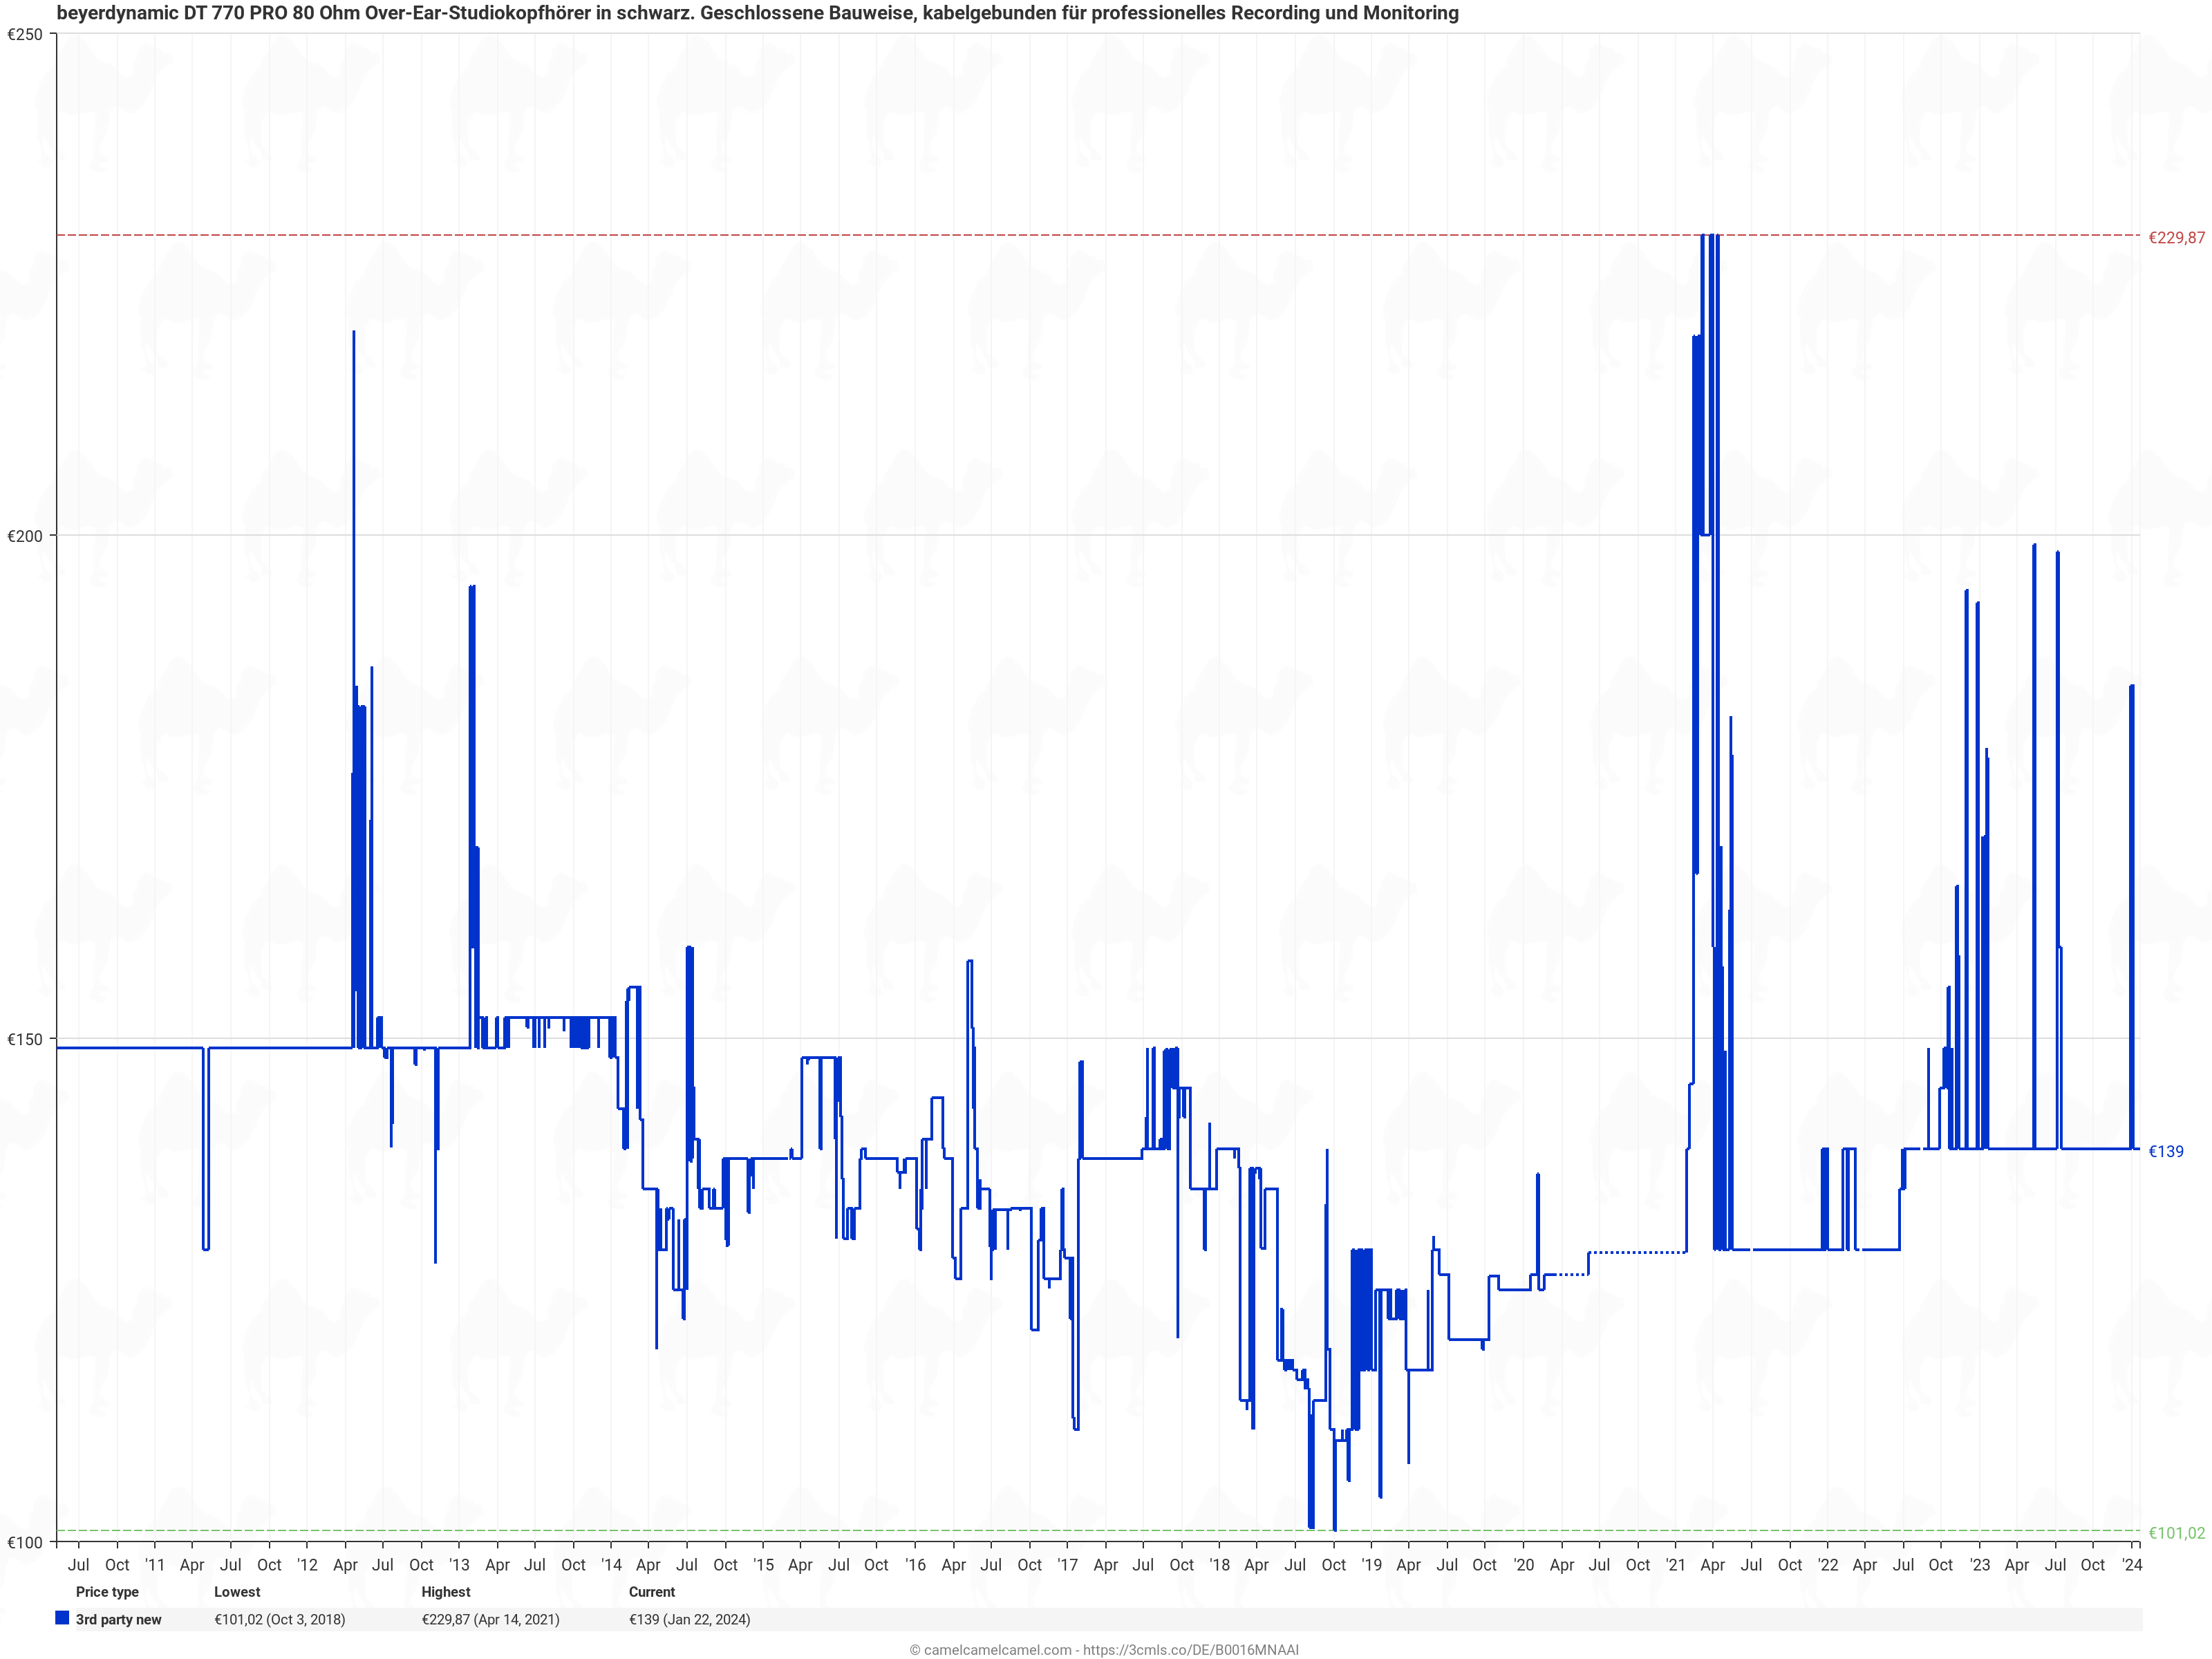

In [17]:
Image.open(collector.paths_to_charts['new'])

In [18]:
collector.get_start_end_dates_from_charts()

In [19]:
collector.start_end_dates

{'amazon': {'first_date': datetime.datetime(2014, 7, 1, 0, 0),
  'last_date': datetime.datetime(2023, 1, 1, 0, 0)},
 'new': {'first_date': datetime.datetime(2010, 7, 1, 0, 0),
  'last_date': datetime.datetime(2023, 1, 1, 0, 0)}}

In [24]:
seller = 'new'
file_name = collector.paths_to_charts[seller]

img = Image.open(file_name)

img_array = np.array(img)

text_extracts = []

for k, multiplier in enumerate(
    [
        1 / 2,   # Bottom half of the image
        1 / 3,   # Bottom two thirds of the image
        2 / 3,   # Bottom third of the image
        3 / 4    # Bottom quarter of the image
    ]
):
    img_array_tmp = img_array[int(img_array.shape[0] * multiplier):, :, :].copy()

    img = Image.fromarray(img_array_tmp)

    text = pytesseract.image_to_string(img, lang='eng')

    # print(text)

    text_tmp = text[text.find('€'):text.rfind('Price type')]

    if len(text_tmp) == 0 and k == 2:
        if len(text_extracts[0]) == 0 and len(text_extracts[1]) == 0:
            text_tmp = text[:text.rfind('Price type')]

    text_extracts.append(text_tmp)

In [25]:
text_extracts

["€150 4\n\n9.00\nJul Oct '11 Apr Jul Oct ‘12 Apr Jul Oct ‘13 Apr Jul Oct ‘14 Apr Jul Oct ‘15 Apr Jul Oct '16 Apr Jul Oct ‘17 Apr Jul Oct '18 Apr Jul Oct ‘19 Apr Jul Oct '20 Apr Jul Oct '21 Apr Jul Oct '22 Apr Jul Oct '23 Apr Jul Oct '24\n",
 "€150 4\n\n9.00\nJul Oct ‘11 Apr Jul Oct '12 Apr Jul Oct '13 Apr Jul Oct '14 Apr Jul Oct ‘15 Apr Jul Oct '16 Apr Jul Oct ‘17 Apr Jul Oct ‘18 Apr Jul Oct ‘19 Apr Jul Oct '20 Apr Jul Oct '21 Apr Jul Oct '22 Apr Jul Oct '23 Apr Jul Oct '24\n",
 '€100\n\nyee\n\nLW\n\nUM Lt...\n\nJul Oct ‘11 Apr Jul\n\nOct\n\n',
 "€100 T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T\n\nJul Oct '11 Apr Jul Oct ‘12 Apr Jul Oct ‘13 Apr Jul Oct ‘14 Apr Jul Oct ‘15 Apr Jul Oct '16 Apr Jul Oct ‘17 Apr Jul Oct '18 Apr Jul Oct ‘19 Apr Jul Oct '20 Apr Jul Oct '21 Apr Jul Oct '22 Apr Jul Oct '23 Apr Jul Oct '24\n"]

In [26]:
get_dates_from_text_extract(text_extracts[0])

('Jan', 2000, 'Jan', 2023)

In [34]:
text_extract = text_extracts[0]

pattern = r'\b(\d{2})[°.]?[ \t](?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)'

potential_first_year_matches = [
    match for match in re.finditer(pattern, text_extract)
]
potential_first_year_matches = [
    match for match in potential_first_year_matches if int(
        ''.join(filter(str.isdigit, match.group(0)))
    ) <= 20
]
potential_first_years = [
    int(''.join(filter(str.isdigit, match.group(0)))) for match in potential_first_year_matches
]
first_year = 2000 + int(potential_first_years[0])

In [35]:
first_year

2011

In [37]:
amazon_price_histories = collector.price_histories['amazon'].copy()

collector.price_histories['amazon'][
    np.logical_and(
        collector.price_histories['amazon']['x_axis_coord'] > 1630, 
        collector.price_histories['amazon']['x_axis_coord'] < 1720
    )
].head()

,x_axis_coord,trusted,price,date
1459,1631.0,False,5.302095,2020-03-11 01:13:29.614753200
1460,1636.0,False,5.302095,2020-03-15 18:18:36.628250400
1461,1637.0,False,5.302095,2020-03-16 16:55:38.030952000
1462,1638.0,False,5.302095,2020-03-17 15:32:39.433650000
1463,1639.0,False,5.302095,2020-03-18 14:09:40.836351600


In [29]:
seller = 'amazon'
file_name = collector.paths_to_charts[seller]

img = Image.open(file_name)

img_array = np.array(img)

text_extracts = []
img_extracts = []

for k, multiplier in enumerate(
    [
        1 / 2,   # Bottom half of the image
        1 / 3,   # Bottom two thirds of the image
        2 / 3    # Bottom third of the image
    ]
):
    img_array_tmp = img_array[int(img_array.shape[0] * multiplier):, :, :].copy()
    
    img_extracts.append(img_array_tmp)

    img = Image.fromarray(img_array_tmp)

    text = pytesseract.image_to_string(img, lang='eng')

    # print(text)

    text_tmp = text[text.find('€'):text.rfind('Price type')]

    if len(text_tmp) == 0 and k == 2:
        if len(text_extracts[0]) == 0 and len(text_extracts[1]) == 0:
            text_tmp = text[:text.rfind('Price type')]

    text_extracts.append(text_tmp)

In [30]:
text_extracts

["€120 17 T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T ™\n\nJul Aug Sep Oct Nov Dec '20 Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec '21 Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec '22 Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec '23 Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec '24\n",
 "€120 T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T ™\nJul Aug Sep Oct Nov Dec '20 Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec '21 Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec '22 Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec '23 Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec '24\n",
 "€170 5\n\nCe Pe | Ee | ey\n\n€120 T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T ™\nJul Aug Sep Oct Nov Dec '20 Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec '21 Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec '22 Feb Mar Apr May Jun Jul Aug Sep Oct Nov De

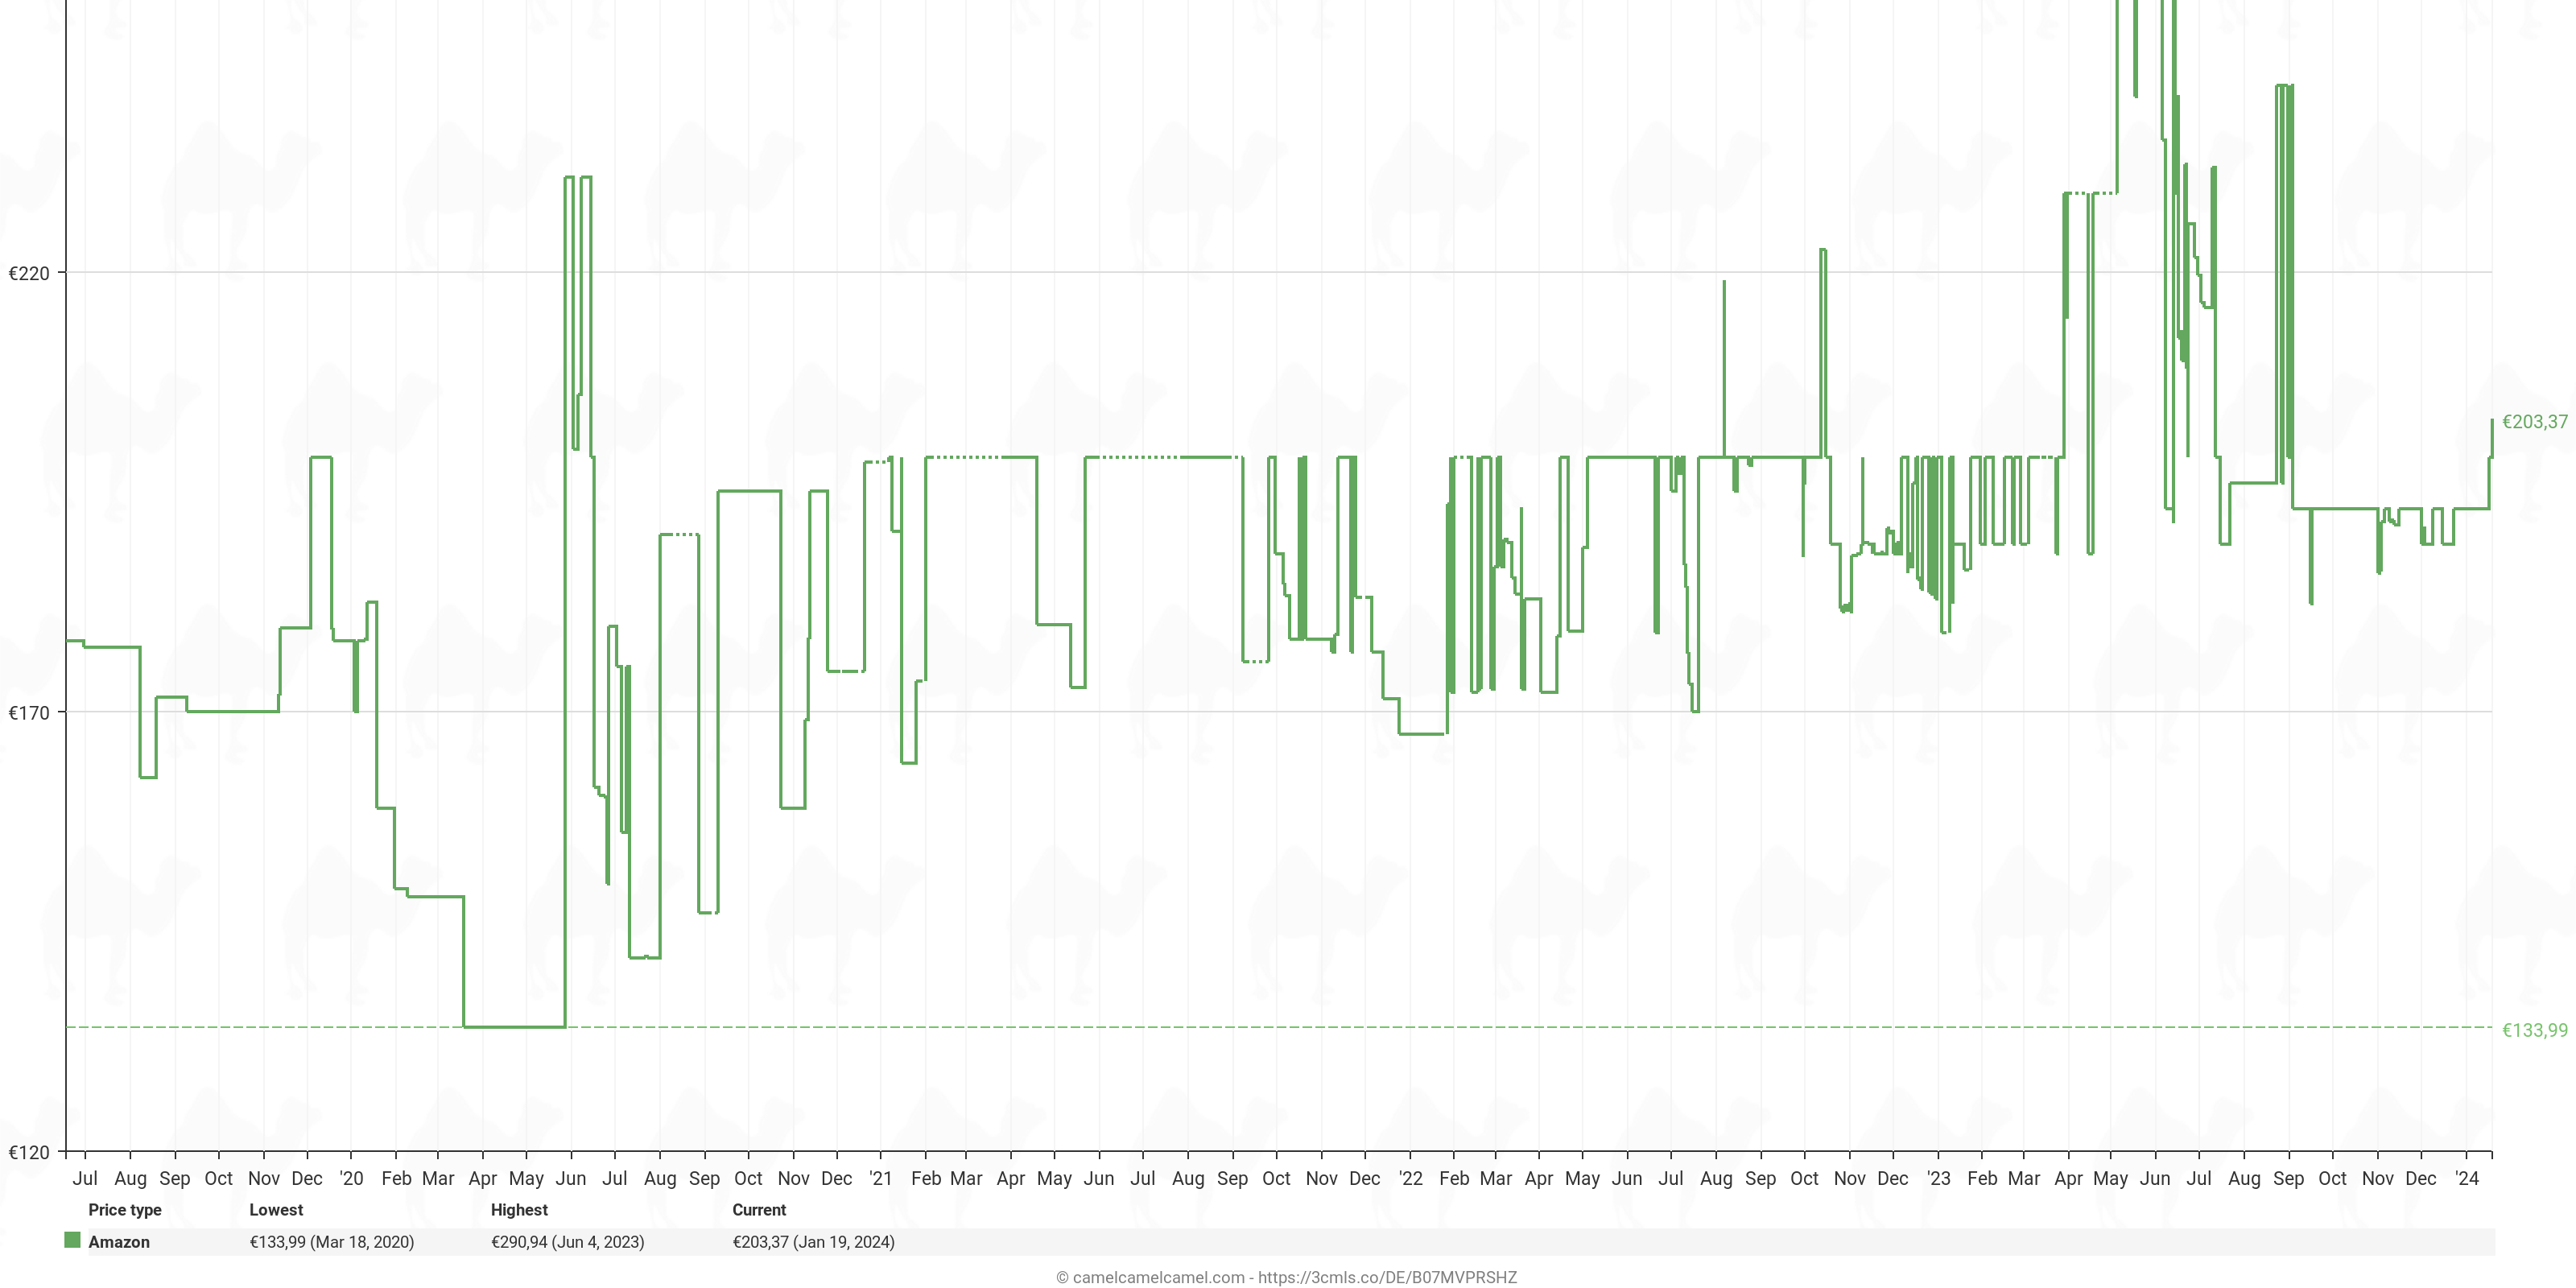

In [32]:
Image.fromarray(img_extracts[1])

In [71]:
first_months = []
first_years = []
last_months = []
last_years = []

for i, text_extract in enumerate(text_extracts):

    if i < len(text_extracts) - 1:

        if len(text_extract) > 0:

            try:

                first_month, first_year, last_month, last_year = get_dates_from_text_extract(text_extract)
                
                print(first_year)

                first_months.append(first_month)
                first_years.append(first_year)
                last_months.append(last_month)
                last_years.append(last_year)

            except IndexError:

                continue

        else:

            continue

    else:

        first_month, first_year, last_month, last_year = get_dates_from_text_extract(text_extract)
        
        print(first_year)

        first_months.append(first_month)
        first_years.append(first_year)
        last_months.append(last_month)
        last_years.append(last_year)

# For each component of the dates we are after, we take the value that comes out most often
first_month = max(first_months, key=first_months.count)
first_year = max(first_years, key=first_years.count)
last_month = max(last_months, key=last_months.count)
last_year = max(last_years, key=last_years.count)

2017
2019
2019


In [72]:
print(first_month, first_year)
print(last_month, last_year)

Jul 2019
Jan 2024


In [36]:
lst = ['a', 'b', 'c']

In [37]:
max(lst, key=lst.count)

'a'

In [104]:
collector.convert_coordinates_to_timestamps()

In [105]:
collector.price_histories['new'].head()

,x_axis_coord,trusted,price,date
0,70.0,True,29.898911,2017-11-01 00:00:00.000000000
1,71.0,True,29.898911,2017-11-01 17:47:47.434970400
2,72.0,True,29.898911,2017-11-02 11:35:34.869937200
3,73.0,True,29.898911,2017-11-03 05:23:22.304907600
4,74.0,True,28.936507,2017-11-03 23:11:09.739874400


In [41]:
collector.price_histories['amazon'][
    collector.price_histories['amazon']['date'] > pd.to_datetime("2020-03-10")
]

,trusted,price,date
1458,False,5.302095,2020-03-10 02:36:28.212051600
1459,False,5.302095,2020-03-11 01:13:29.614753200
1460,False,5.302095,2020-03-15 18:18:36.628250400
1461,False,5.302095,2020-03-16 16:55:38.030952000
1462,False,5.302095,2020-03-17 15:32:39.433650000
...,...,...,...
2883,True,6.895135,2023-12-28 05:31:54.389200799
2884,True,6.895135,2023-12-29 04:08:55.791898800
2885,True,6.895135,2023-12-30 02:45:57.194600400
2886,True,6.895135,2023-12-31 01:22:58.597298400


In [106]:
collector.format_price_histories()

In [108]:
collector.price_histories['new']['trusted'].unique()

array([ True, False])

In [109]:
price_history = pd.concat([v for _, v in collector.price_histories.items()])

In [116]:
price_history['trusted'].astype(bool).unique()

array([ True, False])

In [50]:
collector.price_histories['amazon'][
    collector.price_histories['amazon']['date'] > pd.to_datetime("2020-03-01")
].head(20)

,trusted,price,date,sku,country,unit,seller
1453,False,5.302095,2020-03-01 15:03:15.587751600,B00X7792IE,France,€,amazon
1454,False,5.302095,2020-03-02 13:40:16.990449600,B00X7792IE,France,€,amazon
1455,False,5.302095,2020-03-03 12:17:18.393151200,B00X7792IE,France,€,amazon
1456,False,5.302095,2020-03-08 05:22:25.406652000,B00X7792IE,France,€,amazon
1457,False,5.302095,2020-03-09 03:59:26.809350000,B00X7792IE,France,€,amazon
1458,False,5.302095,2020-03-10 02:36:28.212051600,B00X7792IE,France,€,amazon
1459,False,5.302095,2020-03-11 01:13:29.614753200,B00X7792IE,France,€,amazon
1460,False,5.302095,2020-03-15 18:18:36.628250400,B00X7792IE,France,€,amazon
1461,False,5.302095,2020-03-16 16:55:38.030952000,B00X7792IE,France,€,amazon
1462,False,5.302095,2020-03-17 15:32:39.433650000,B00X7792IE,France,€,amazon


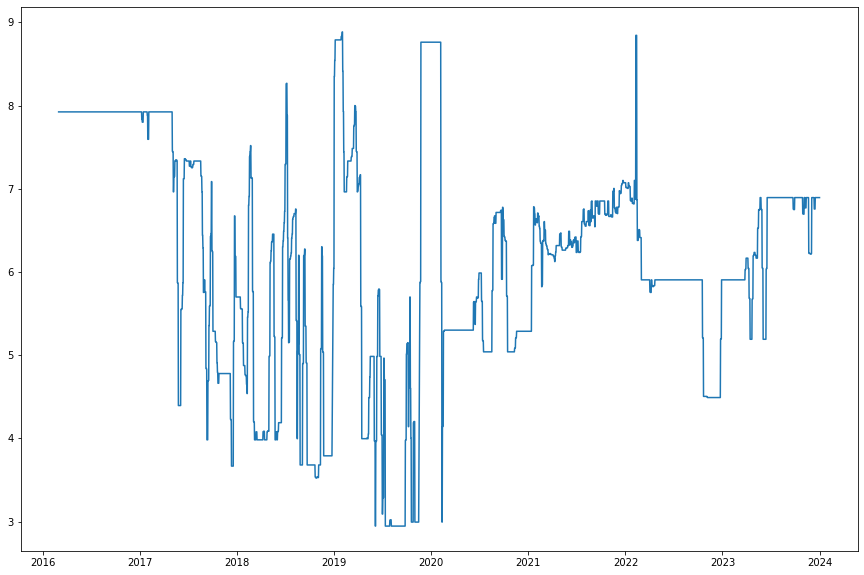

In [26]:
plt.figure(figsize=(15, 10))
plt.plot(collector.price_histories['amazon']['date'], collector.price_histories['amazon']['price'])
# plt.plot(collector.price_histories['amazon']['date'], collector.price_histories['amazon']['trusted'])
plt.show();

In [85]:
path_to_price_history_csv = os.path.join(
    os.path.dirname(os.path.dirname(os.path.abspath("__file__"))),
    "dst_incidence", "data", "prices", "price_history.csv"
)
price_history_csv = pd.read_csv(path_to_price_history_csv)

/Users/Paul-Emmanuel/.pyenv/versions/3.7.7/envs/lewagon-data/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [86]:
price_history_csv['sku'].nunique()

45

In [87]:
price_history_csv.head()

,trusted,price,date,sku,country,unit,seller
0,True,80.938098,2012-10-01 00:00:00,B0000C73CQ,France,€,amazon
1,True,80.938098,2012-10-02 08:43:48.609361200,B0000C73CQ,France,€,amazon
2,True,80.880810,2012-10-03 17:27:37.218718800,B0000C73CQ,France,€,amazon
3,True,80.880810,2012-10-05 02:11:25.828080,B0000C73CQ,France,€,amazon
4,True,34.821621,2012-10-06 10:55:14.437437600,B0000C73CQ,France,€,amazon


In [88]:
price_history_csv['trusted'].unique()

array(['True', 'False', '1.0', '0.0', True, False], dtype=object)

In [91]:
price_history_csv[price_history_csv['trusted'] == '1.0']

,trusted,price,date,sku,country,unit,seller
125060,1.0,29.898911,2017-11-01 00:00:00,B019H693FA,France,€,new
125061,1.0,29.898911,2017-11-01 17:47:47.434970400,B019H693FA,France,€,new
125062,1.0,29.898911,2017-11-02 11:35:34.869937200,B019H693FA,France,€,new
125063,1.0,29.898911,2017-11-03 05:23:22.304907600,B019H693FA,France,€,new
125064,1.0,28.936507,2017-11-03 23:11:09.739874400,B019H693FA,France,€,new
...,...,...,...,...,...,...,...
192243,1.0,13.969152,2023-08-28 11:45:32.301612,B073YQ5KSX,France,€,new
192244,1.0,13.969152,2023-08-29 02:40:15.805070400,B073YQ5KSX,France,€,new
192245,1.0,13.969152,2023-08-29 17:34:59.308528800,B073YQ5KSX,France,€,new
192246,1.0,13.969152,2023-08-30 08:29:42.811987200,B073YQ5KSX,France,€,new


In [121]:
price_history_csv = pd.read_csv(
    path_to_price_history_csv,
    dtype={"trusted": bool, "price": float, "date": str, "sku": str, "country": str, "seller": str},
    parse_dates=['date']
)
extract = price_history_csv[
    np.logical_and(
        price_history_csv['country'] == collector.country,
        np.logical_and(
            price_history_csv['sku'] == collector.sku_reference,
            price_history_csv['seller'] == "amazon"
        )
    )
]

In [66]:
extract[
    extract['date'] > pd.to_datetime("2020-02-15")
].head(20)

,trusted,price,date,sku,country,unit,seller
115771,True,4.148514,2020-02-15 13:10:53.144551200,B00X7792IE,France,€,amazon
115772,True,5.288361,2020-02-16 11:47:54.547249200,B00X7792IE,France,€,amazon
115773,True,5.288361,2020-02-17 10:24:55.949950800,B00X7792IE,France,€,amazon
115774,True,5.288361,2020-02-18 09:01:57.352652400,B00X7792IE,France,€,amazon
115775,True,5.288361,2020-02-19 07:38:58.755350400,B00X7792IE,France,€,amazon
115776,True,5.302095,2020-02-20 06:16:00.158051999,B00X7792IE,France,€,amazon
115777,True,5.302095,2020-02-21 04:53:01.560750000,B00X7792IE,France,€,amazon
115778,True,5.302095,2020-02-22 03:30:02.963451600,B00X7792IE,France,€,amazon
115779,True,5.302095,2020-02-23 02:07:04.366149600,B00X7792IE,France,€,amazon
115780,True,5.302095,2020-02-24 00:44:05.768851200,B00X7792IE,France,€,amazon


In [122]:
amazon_price_history = extract.copy()

In [123]:
amazon_price_history['transition'] = np.logical_and(
    amazon_price_history['trusted'] != amazon_price_history['trusted'].shift(1),
    ~amazon_price_history['trusted'].shift(1).isnull()
)

amazon_price_history['transition#'] = amazon_price_history['transition'].cumsum()

In [124]:
amazon_price_history['transition#']

Series([], Name: transition#, dtype: int64)

In [69]:
amazon_price_history[
    amazon_price_history['date'] > pd.to_datetime("2020-02-15")
].head(20)

,trusted,price,date,sku,country,unit,seller,transition,transition#
115771,True,4.148514,2020-02-15 13:10:53.144551200,B00X7792IE,France,€,amazon,False,10
115772,True,5.288361,2020-02-16 11:47:54.547249200,B00X7792IE,France,€,amazon,False,10
115773,True,5.288361,2020-02-17 10:24:55.949950800,B00X7792IE,France,€,amazon,False,10
115774,True,5.288361,2020-02-18 09:01:57.352652400,B00X7792IE,France,€,amazon,False,10
115775,True,5.288361,2020-02-19 07:38:58.755350400,B00X7792IE,France,€,amazon,False,10
115776,True,5.302095,2020-02-20 06:16:00.158051999,B00X7792IE,France,€,amazon,False,10
115777,True,5.302095,2020-02-21 04:53:01.560750000,B00X7792IE,France,€,amazon,False,10
115778,True,5.302095,2020-02-22 03:30:02.963451600,B00X7792IE,France,€,amazon,False,10
115779,True,5.302095,2020-02-23 02:07:04.366149600,B00X7792IE,France,€,amazon,False,10
115780,True,5.302095,2020-02-24 00:44:05.768851200,B00X7792IE,France,€,amazon,False,10


In [70]:
amazon_trusted_dfs = []
amazon_not_trusted_dfs = []

In [76]:
extract_bis = amazon_price_history[amazon_price_history['transition#'] == 11].copy()

In [78]:
extract_bis.head()

,trusted,price,date,sku,country,unit,seller,transition,transition#
115782,False,5.302095,2020-02-29 16:26:14.185050000,B00X7792IE,France,€,amazon,True,11
115783,False,5.302095,2020-03-01 15:03:15.587751600,B00X7792IE,France,€,amazon,False,11
115784,False,5.302095,2020-03-02 13:40:16.990449600,B00X7792IE,France,€,amazon,False,11
115785,False,5.302095,2020-03-03 12:17:18.393151200,B00X7792IE,France,€,amazon,False,11
115786,False,5.302095,2020-03-08 05:22:25.406652000,B00X7792IE,France,€,amazon,False,11


In [84]:
bool(extract_bis['trusted'].unique()[0])

True

In [81]:
for i in range(amazon_price_history['transition#'].max() + 1):
    extract_bis = amazon_price_history[amazon_price_history['transition#'] == i].copy()

    if bool(extract_bis['trusted'].unique()[0]):
        amazon_trusted_dfs.append(extract_bis)

    else:
        amazon_not_trusted_dfs.append(extract_bis)

In [83]:
amazon_not_trusted_dfs

[]

In [64]:
price_history_csv.dtypes

trusted     object
price      float64
date        object
sku         object
country     object
unit        object
seller      object
dtype: object

In [14]:
collector.fetch_product_information()

collector.build_price_history_from_charts()
collector.get_start_end_dates_from_charts()
collector.get_end_date_from_price_history_summary()
collector.convert_coordinates_to_timestamps()

collector.format_price_histories()
collector.format_price_history_summary()
collector.format_product_data()
collector.build_collection_metadata()

/Users/Paul-Emmanuel/.pyenv/versions/3.7.7/envs/lewagon-data/lib/python3.7/site-packages/dst_incidence/amazon_prices.py:226: RuntimeWarning: Mean of empty slice.
  avg_y_coord = img_array.shape[0] - y_coords.mean()
/Users/Paul-Emmanuel/.pyenv/versions/3.7.7/envs/lewagon-data/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
collector.price_history_summary # ['first_date']

,sku,country,unit,seller,min_price,min_price_date,max_price,max_price_date,current_price,current_price_date,average_price
0,B0000C73CQ,France,€,amazon,10.99,2019-03-29,126.94,2012-09-27,16.90,2023-09-07,16.22
1,B0000C73CQ,France,€,new,1.99,2013-05-31,29.07,2023-06-07,NaN,NaT,16.54
2,B0000C73CQ,France,€,used,8.90,2019-10-09,68.03,2017-05-08,16.56,2024-01-16,16.63


In [16]:
collector.price_histories

{'amazon':           price                          date         sku country unit  seller
 0           NaN 2013-10-01 00:00:00.000000000  B0000C73CQ  France    €  amazon
 1           NaN 2013-10-02 05:57:46.207846800  B0000C73CQ  France    €  amazon
 2     80.938098 2013-10-03 11:55:32.415690000  B0000C73CQ  France    €  amazon
 3     80.938098 2013-10-04 17:53:18.623536800  B0000C73CQ  France    €  amazon
 4     80.880810 2013-10-05 23:51:04.831383600  B0000C73CQ  France    €  amazon
 ...         ...                           ...         ...     ...  ...     ...
 2901  16.947905 2024-01-16 02:05:51.823813200  B0000C73CQ  France    €  amazon
 2902  16.947905 2024-01-17 08:03:38.031660000  B0000C73CQ  France    €  amazon
 2903  16.947905 2024-01-18 14:01:24.239503200  B0000C73CQ  France    €  amazon
 2904  16.947905 2024-01-19 19:59:10.447350000  B0000C73CQ  France    €  amazon
 2905  16.947905 2024-01-21 01:56:56.655196800  B0000C73CQ  France    €  amazon
 
 [2906 rows x 6 columns]}

In [17]:
collector.sellers

{'amazon': {}}